In [56]:
%matplotlib inline
import pennylane as qml
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from IPython import display



n_wires = 8
n_layers = 4
@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def circuit(x, weights):

    # Embedding
    for i in range(n_wires):
        qml.RY(2*i*torch.arccos(x),wires = i)
    
    # Variational ansatz
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))

    # Cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(x, weights, bias):
    vcircuit = torch.vmap(circuit, in_dims=(0,None))
    return vcircuit(x, weights) + bias

x = torch.linspace(0.01,.9,101)
dudx = lambda x, u: 4*u - 6*np.power(u,2) +np.sin(50*x) + u*np.cos(25*x) - 0.5
sol_analytical_fnc = solve_ivp(dudx, [0,0.9], [0.75], dense_output=True)
x_np = np.linspace(0.01,.9,101)
u = torch.tensor(sol_analytical_fnc.sol(x_np))

def loss_fnc(weights:torch.Tensor, bias:torch.Tensor) ->torch.Tensor:
    weights.requires_grad =True
    bias.requires_grad = True
    x = torch.linspace(0.01,.9,101, requires_grad=True)

    # u_pred = my_model(x, theta, bias)
    # return torch.mean( (u_pred-u)**2)

    u_pred = my_model(x, weights, bias)
    grad_outputs = torch.ones_like(u_pred)
    dudx = autograd.grad(u_pred, x, grad_outputs=grad_outputs, create_graph=True)[0]
    res = dudx - 4*u_pred + 6*u_pred.pow(2) -torch.sin(50*x) - u_pred*torch.cos(25*x) + 0.5
    loss_pde = torch.mean(res**2)

    u_0_pre = my_model(torch.zeros_like(x), weights, bias)
    u_0 = 0.75*torch.ones_like(x)
    loss_boundary = torch.mean((u_0_pre - u_0)**2)
    return 3*loss_boundary + loss_pde


def optimize(n_iter = 100, verbose=0):
    # Solve ODE numerically
    x = torch.linspace(0.01,.9,101)
    dudx = lambda x, u: 4*u - 6*np.power(u,2) +np.sin(50*x) + u*np.cos(25*x) - 0.5
    sol_analytical = solve_ivp(dudx, [0,0.9], [0.75], t_eval=x)

    def update(verbose):
        if verbose == 1:
            print(f"Step: {i}  Loss: {loss}")
        elif verbose == 2:
            fig = plt.figure()
            fig.set_figheight(5)
            fig.set_figwidth(12)

            # Add energy plot on column 1
            ax1 = fig.add_subplot(121)
            ax1.plot(range(len(loss_history)), loss_history, "black")
            ax1.plot(range(len(loss_history)), loss_history, "black")
            ax1.set_yscale('log')
            ax1.set_xlabel("Optimization step", fontsize=13)
            ax1.set_ylabel("Loss", fontsize=13)

            ax2 = fig.add_subplot(122)
            f_qc = my_model(x, weights, bias).detach()
            ax2.plot( x, f_qc, "r", ls="dashed")
            ax2.plot(sol_analytical.t, sol_analytical.y[0], "g", ls="dashed")
            ax2.legend(["QCML", "Analytical"], fontsize=13)
            ax2.set_xlabel("u(x)", fontsize=13)
            ax2.set_ylabel("x", fontsize=13)

            f_qc = my_model(x, weights, bias).detach()
            plt.plot( x, f_qc, "r", ls="dashed")
            display.clear_output(wait=True)
            plt.show()
            print(f"Step: {i}  Loss: {loss}")
    
    for i in range(1,n_iter+1):
        opt.zero_grad()
        loss = loss_fnc(weights, bias)
        loss.backward()
        opt.step()

        if i%10 == 0 : update(verbose)
        loss_history.append(loss.detach())
#theta = torch.rand((n_wires,3), requires_grad=True)
weights = torch.rand((n_layers,n_wires), requires_grad=True)
bias = torch.rand(1, requires_grad=True)
opt = torch.optim.Adam([weights, bias], lr=0.01)
loss_history = []

In [58]:
opt.param_groups[0]["lr"] = 0.01
optimize(n_iter=500, verbose=1)

Step: 10  Loss: 0.018349176627005498
Step: 20  Loss: 0.017192830862637704


KeyboardInterrupt: 

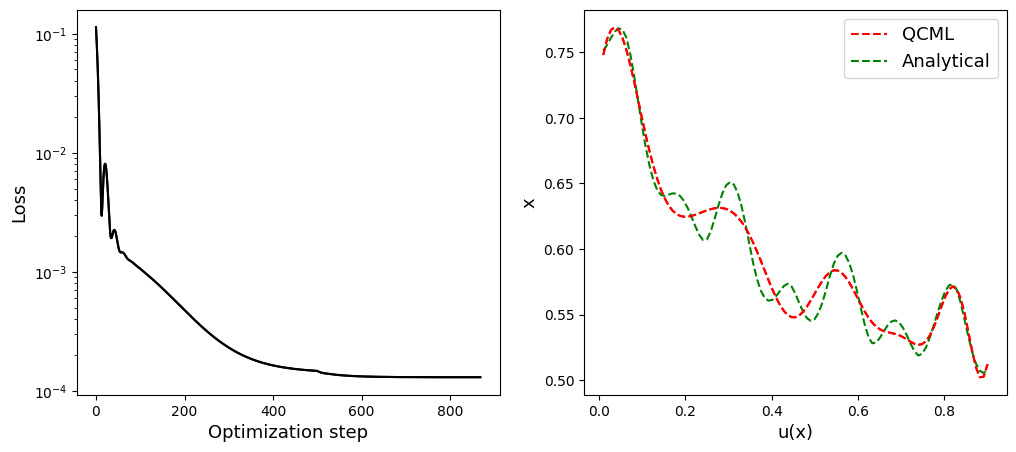

Step: 70  Loss: 0.0001306551059347843


KeyboardInterrupt: 

In [51]:
# %timeit -n1 -r1 
opt.param_groups[0]["lr"] = 0.1
optimize(n_iter=300, verbose=2)
opt.param_groups[0]["lr"] = 0.01
optimize(n_iter=500, verbose=2)
opt.param_groups[0]["lr"] = 0.001
optimize(n_iter=100, verbose=2)

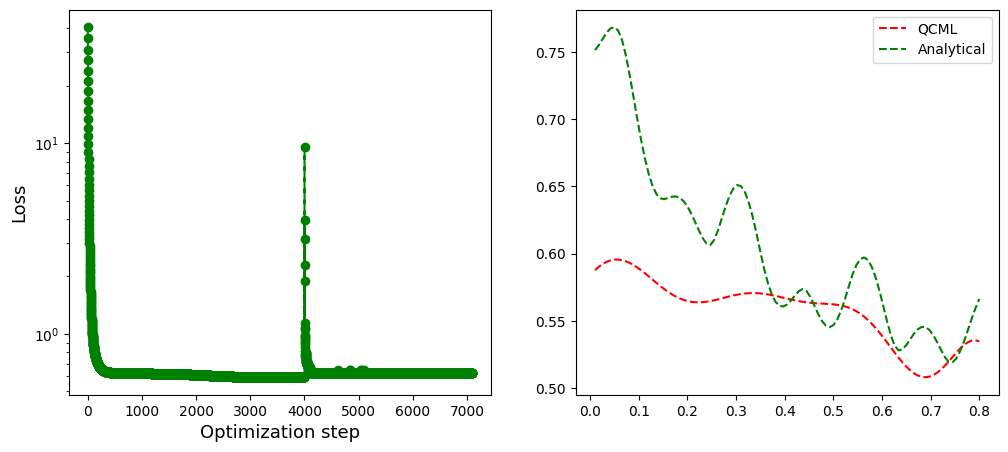

In [92]:
# Solve ode numerically 
opt.param_groups[0]["lr"] = 0.01
optimize(n_iter=300, verbose=2)

dudx = lambda x, u: 4*u - 6*np.power(u,2) +np.sin(50*x) + u*np.cos(25*x) - 0.5
sol_analytical = solve_ivp(dudx, [0,0.9], [0.75], t_eval=x)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_yscale('log')
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = torch.linspace(0.01,.8,101)
f_qc = my_model(x, weights, bias).detach()
ax2.plot( x, f_qc, "r", ls="dashed")
ax2.plot(sol_analytical.t, sol_analytical.y[0], "g", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()